<a href="https://colab.research.google.com/github/carmengomezmena/ExtremelyDarkImages_DeepLearningGroup30_Reproducibility/blob/main/Blog_Post_Group_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 30 - CS4240 - Restoring Extremely Dark Images in Real Time 

# Introduction 


Although a lot of work exists in the deep learning community on restoring extreme low-light images, M. Lamba and K. Mitra, from the Indian Institute of Technology Madras, believed that improvement of the practicallity of these algorithims in real-world applications was possible. The existent solutions were not fast and lightweight enough. Therefore, they inspired themselves on neural network architecture that accomplished good restoration results, and modified it in such a way as to preserve the quality of the restoration while reducing the computational time. The authors claim that their method is faster, cheaper, lighter and more generalizable than current state-of-the-art methods.

The community of Machine Learning has grown significantly over the past few decades, and contributions such as that by M. Lamba and K. Mitra, add to the excitement of this developing technology. It is important though, for the artificial intelligence field to sustain itself in the long term, that research contributions such as these are reproducible. This blog post reports our attempt at reproducing the results of the deep learning low-light image-restoring model presented on the paper 'Restoring Extremely Dark Images in Real Time' by M. Lamba and K. Mitra. 


# Reproducibility Plan 

We are three Aerospace Engineering Master students at TU Delft, and over the course of 4 weeks we have attempted the reproduction of some of the results presented in this paper. This Reproducibility Project is part of the course CS4240 "Deep Learning". The original repository was used as starting point of the project, along with the 'Sony' database from the "Learning to See in the Dark" study. We have followed these steps:

1. Studied the model description
2. Studied the authors original code
3. Conducted reproducibility experiments
    - Re-train the model and confirm results claimed on paper
    - Test original trained model with new images to study generabizability
    - Test effect of changing weight initialization method

Deep learning is slowly making its way into many engineering fields, due to our non-computer science background, we were curious to see how this would affect the easiness of reproduction and we have made some observations rearding this in the vlog.


# Model Architecture

First, let's summarize the model presented in the paper. The authors claim several breakthroughs and advantages of their method:

1. It is faster, cheaper, lighter: their architecture is supposedly 5 - 100 times fast than similar networks, 6 - 20 times computationally cheaper, and has 3 - 11 times fewer parameters. 
2. It sets an example for using parallelism to increase restoration speed without impacting quality.
3. It suggests an improvement to the widely used Residual Dense Block (RDB*).
4. It applies a new method of pre-amplification that can be applied to input images for any model, including pre-trained ones.
5. It can be generalized better than existing methods to other cameras and subsequent tasks, such as object detection.

In order to understand better this claims this section presents a summary of the architecture of the model. Conceptually, one of the main differences between the author's work and previous work, that used U-net style encoder-decoder architecture, is the way their architecture supports parallelism. This difference is expressed graphically in Figure 2 of their paper:

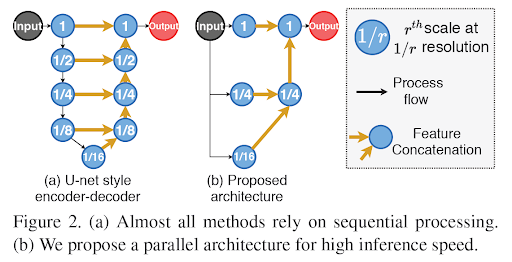

The architecture proposed by the authors lends itself to parallel computations with each resolution operating directing from the input rather than from the previous resolution scale. In fact, Figure 2 reveals another aspect in which the proposed architecture differs from other methods: there are fewer resolution branches. The exact architecture used is described by Figure 3(a) below:

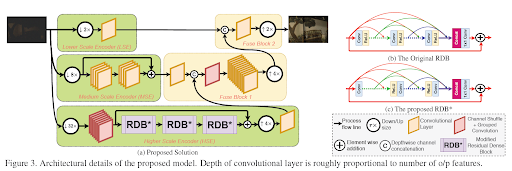

In Figure 3(a), the network’s architecture can be examined, with the modification to the RDB blocks, RDB*, explained in Figure 3(b). The same input is given to three encoder channels, each operating on a different resolution: 12, 18, and 32 respectively for the Lower, Medium, and Higher scale encoders. The authors decided to perform only one convolution on the LSE level with the highest image resolution (still downsampled by a factor of 2) with a large kernel to extract more information. Then, they determined the parameters of HSE and MSE such that those layers would have approximately the same number of operations.


Another key point in the discussion of the architecture is the modifications made to the RDB blocks, becoming RDB* blocks. The classic structure of the RDB is shown in Figure 3(b) and the authors’ modifications in Figure 3(c). The authors changed the residual such that the information from the first convolution is transmitted to the concatenation unfiltered. In other words, more information is carried through.

Pre-amplification is also an important part of the methodology discussed in the article and part of the pseudo-architecture since the method used is directly linked to the input layer. Here the authors have chosen to deviate from the commonly used model described in SID [], which compares the intensity of pixels in the input image with that of pixels in the ground truth image. Instead, the authors assign pixels to bins based on their intensity value on a logarithmic scale. Then they assign weights to each bin, also on a logarithmic scale. The results is expressed by equation 5 of their article:

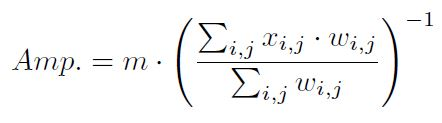

In order to understand this new amplification better, we drew a graphical representation of this weight assignment logic. This is shown below for a simplified case of 5 bins in the left, and for the original model case of 127 bins in the right:

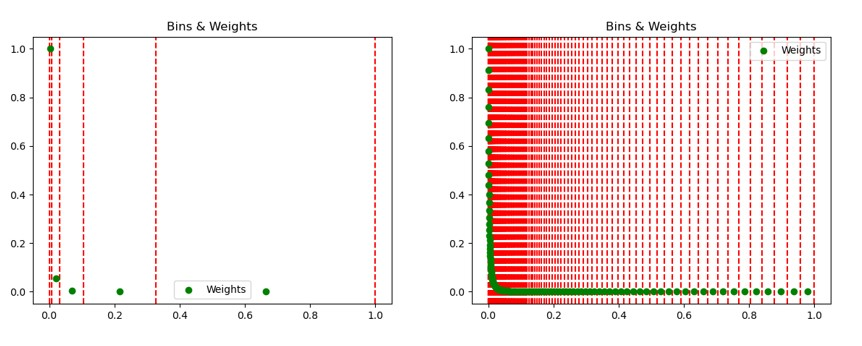

Now that we have an overview of the model, let's link it to the paper’s claims:
1. Faster, cheaper, lighter.
  - By downsampling to only 3 resolutions instead of 5, this architecture reduces significantly the number of learnable parameters and is therefore lighter than many comparable networks.
  - The fact that each resolution (up to the fuse boxes) can be computed in parallel speeds up the runtime considerably.
2. Parallelism:
  - By downsampling the input image itself rather than the previous downsampled image the network can run a part of its computations in parallel, up to the fuse box.
3. RDB*:
  - By modifying the RDB to allow more information through, in combination with the leakyReLU method, the authors propose a new architecture style and a reason why it would work better.
4. Pre-amplification:
  - By removing the need for a ground truth to pre-amplify, the authors start the transition of this technique to real-world application, where the ground truth might not be available.
  - By assigning emphasized weights to pixels with very low intensity, the restoration avoids artifacts and bright spots
5. Generalizability:
  - This objective is addressed by the pixelshuffle algorithm and the automated resizing of the input image. Pixelshuffling is used to downsample the raw image and demosaic it and to perform the same operation in reverse in the fuse boxes.


# Stepping through the code - DEMO

A clear way of understanding how th emodel works is to apply it. This section presents a demo of the original model. by presenting code written by the authors (and further explained with our interpretations). This step was critical for our team to understand the workings of the model and we must say that it was not straight forward due to the lack of comments in the original code. 

Once the network is trained, the following steps can be used to demo its capabilities. Firstly, some supporting function are needed from the file "common_classes.py", which requires some python modules.

In [3]:
import random
import numpy as np
import os
import torch
from torch.utils.data import Dataset
import rawpy
import glob
import imageio

From the common_classes, the load_data and the run_test classes are needed set up the demo, load trained weigths and format the files correctly for restoration. However, the load_data class uses several other functions that will be defined beforehand. The first is the define_weights function, which initializes 127 weights (because there are 127 bins for pixels of varying intensities) and normalizes them between 1 and 0. The num input determines the order of magnitude of the weigths. For this example, num will be set to 5 when define_weights is called, so the logspace will extend from 0 to 100 000. However, this array is normalized by dividing by the largest number such that the 127 logspaced number then range from 0 to 1 with mostly large numbers and a few very small ones near 0.
The weights are then flipped, such that most of them are close to 0, with a few very close to 1 near the begining of the list

In [5]:
def define_weights(num):
    weights = np.float32((np.logspace(0,num,127, endpoint=True, base=10.0)))
    weights = weights/np.max(weights)
    weights = np.flipud(weights).copy()    
    return weights

The next function to be defined is the  get_na function, which takes as inputs the bins' separation, the weight obtained from the define_weights function, the modified image (this will be discussed with the part_init function) and an overall amplification factor.
The weights are assigned to the bins in a dictionary and a mask is created. The image is then "covered" by this mask, or multiplied, to obtain the pre-amplified image that will go through the network logic. As an additional safeguard against bright and dark spots, the pixel values are bounded between 1 and 300.

In [6]:
def get_na(bins,weights,img_loww,amp=1.0):
    H,W = img_loww.shape
    arr = img_loww*1
    selection_dict = {weights[0]: (bins[0]<=arr)&(arr<bins[1])}
    for ii in range(1,len(weights)):
        selection_dict[weights[ii]] = (bins[ii]<=arr)&(arr<bins[ii+1])
    mask = np.select(condlist=selection_dict.values(), choicelist=selection_dict.keys())
   
    mask_sum1 = np.sum(mask,dtype=np.float64)
    
    na1 = np.float32(np.float64(mask_sum1*0.01*amp)/np.sum(img_loww*mask,dtype=np.float64))

    if na1>300.0:
        na1 = np.float32(300.0)
    if na1<1.0:
        na1 = np.float32(1.0)
    
    selection_dict.clear()

    return na1

Next, part_init is the function that uses the two previous functions to convert a given list of raw images to correct format, pre-amplification included, to feed to the network. This function initialises the bin separation spaces, and for every image in the input file resizes the input image to multiples of 32 if necessary and assigns a mask of pre-amplification. Then each image is normalized between 0 to 1 by substracting the camera bias intensity value of 512 and dividing by the highest pixel value, such that 0 is black and 1 is white. The list of images is returned, ready to be fed to the network!

In [8]:
def part_init(train_files):

    bins = np.float32((np.logspace(0,8,128, endpoint=True, base=2.0)-1))/255.0
    weights5 = define_weights(5)
    train_list = []
    
    for i in range(len(train_files)):
        
        raw = rawpy.imread(train_files[i])
        img = raw.raw_image_visible.astype(np.float32).copy()
        raw.close()
        
        h,w = img.shape
        if h%32!=0:
            print('Image dimensions should be multiple of 32. Correcting the 1st dimension.')
            h = (h//32)*32
            img = img[:h,:]
        
        if w%32!=0:
            print('Image dimensions should be multiple of 32. Correcting the 2nd dimension.')
            w = (w//32)*32
            img = img[:,:w]        
        #print('img is: {}'.format(img))
        img_loww = (np.maximum(img - 512,0)/ (16383 - 512))
        #print('img_loww is: {}'.format(img_loww))
        
        na5 = get_na(bins,weights5,img_loww)   
        
        img_loww = img_loww*na5
            
        train_list.append(img_loww)

        print('Image No.: {}, Amplification_m=1: {}'.format(i+1,na5))
    return train_list

Now, the load_data class can be defined. In the common_classes.py, there are other functions defined in this class, but they are not needed for the demo. The pre-defined part_init function is simply called with the address of the folder with the unprocessed raw images.

In [9]:
class load_data(Dataset):
    """Loads the Data."""
    
    def __init__(self, train_files):    
        print('\n...... Loading all files to CPU RAM\n')
        self.train_list = part_init(train_files)        
        print('\nFiles loaded to CPU RAM......\n')
        
    def __len__(self): #function to get length of training list
        return len(self.train_list)

    def __getitem__(self, idx):  #function to get a certain item (at index idx) from the training list
        img_low = self.train_list[idx]
        return torch.from_numpy(img_low).float().unsqueeze(0) #item is a float and 'unsqueezed'

At this point, the model itself can be examined. To do so, the network.py file's Net class is the ultimate objective. Before it can be directly explored, each componenet of the network needs to be defined. Luckily, they are roughly defined in the order that they appear in the architecture. First is the ICNR, but it does not appear to be used in the demo. Then, the base of the convolution layers is defined, chiefly used in LSE. Next is MSE's ResBlock function, and then the modified RDB block. Once these are defined, the Net class simply initializes all the layers in the correct order. It is also important to notice that since the network is assumed to be trained in this demo, there are only forward passes and no backward passes.

In [10]:
import torch
from torch.nn.utils import weight_norm as wn
import torch.nn as nn

ICNR is pixelshuffle technique that uses an image segmentation method to separate an image according to objects. Pixelshuffling is designed to produce a high resolution image out of a single low resolution input image.
In this case, a kernel is created with weights initialize with a kaiming normal distribution and leakyReLU activation.
More information on pixelshuffling can be found [here](https://nico-curti.github.io/NumPyNet/NumPyNet/layers/pixelshuffle_layer.html).
The kaiming normal distribution is defined by the [paper](https://arxiv.org/abs/1502.01852) by Kaiming et al.

In fact, it is possible that this function never actually gets called, so I might remove this.

The conv_layer function returns a sequence of convolution layers based on the number of in channels, out channels, kernel size, groups, bias, negative slope (for the leakyReLU), batch normalization, weights initialization methods, fanning type, activation sequence, pixelshuffling, upscaling, and weight normalization.

This function then performs a series of if statements depending on the parameters given to create a taylored sequence of convolution layers.

In [13]:
def conv_layer(inc, outc, kernel_size=3, groups=1, bias=False, negative_slope=0.2, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=4, num_classes=3, weight_normalization = True):

    layers = []
    
    if bn:
        m = nn.BatchNorm2d(inc)
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        layers.append(m)
    
    if activation=='before':
            layers.append(nn.LeakyReLU(negative_slope=negative_slope, inplace=False))
        
    if pixelshuffle_init:
        m = nn.Conv2d(in_channels=inc, out_channels=num_classes * (upscale ** 2),
                                  kernel_size=3, padding = 3//2, groups=1, bias=True, stride=1)
        nn.init.constant_(m.bias, 0)
        with torch.no_grad():
            kernel = ICNR(m.weight, upscale, negative_slope, fan_type)
            m.weight.copy_(kernel)
    else:
        m = nn.Conv2d(in_channels=inc, out_channels=outc,
     kernel_size=kernel_size, padding = (kernel_size-1)//2, groups=groups, bias=bias, stride=1)
        init_gain = 0.02
        if init_type == 'normal':
            torch.nn.init.normal_(m.weight, 0.0, init_gain)
        elif init_type == 'xavier':
            torch.nn.init.xavier_normal_(m.weight, gain = init_gain)
        elif init_type == 'kaiming':
            torch.nn.init.kaiming_normal_(m.weight, a=negative_slope, mode=fan_type, nonlinearity='leaky_relu')
        elif init_type == 'orthogonal':
            torch.nn.init.orthogonal_(m.weight)
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
    
    if weight_normalization:
        layers.append(wn(m))
    else:
        layers.append(m)
    
    if activation=='after':
            layers.append(nn.LeakyReLU(negative_slope=negative_slope, inplace=False))
            
    return nn.Sequential(*layers)

The ResBlock simply returns the sum of a set of convolution layers added to the input.

In [14]:
class ResBlock(nn.Module):    
    def __init__(self,in_c):
        super(ResBlock, self).__init__()
                
        self.conv1 = conv_layer(in_c, in_c, kernel_size=3, groups=1, bias=True, negative_slope=0.2, bn=False, init_type='kaiming', fan_type='fan_in', activation='after', pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        
        self.conv2 = conv_layer(in_c, in_c, kernel_size=3, groups=1, bias=True, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)

    def forward(self, x):
        return self.conv2(self.conv1(x)) + x

The make_dense function together with the RDB function implement the RDB*. As a reminder of figure 3(c) from earlier, this block is composed of an initial convolution layer, followed by grouped leakyReLU and convolution layers, and ends in another leakyReLU with a convolution layer. The make_dense function is used to differentiate between the first block, middle block and the last block. The difference being whether a leakyReLU is applied to this block, and if it is the last block, the negative slope also changes for the leakyReLU.

In [16]:
class make_dense(nn.Module):
    
    def __init__(self, nChannels=64, growthRate=32, pos=False):
        super(make_dense, self).__init__()
        
        kernel_size=3
        if pos=='first':
            self.conv = conv_layer(nChannels, growthRate, kernel_size=kernel_size, groups=1, bias=False, negative_slope=0.2, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        elif pos=='middle':
            self.conv = conv_layer(nChannels, growthRate, kernel_size=kernel_size, groups=1, bias=False, negative_slope=0.2, bn=False, init_type='kaiming', fan_type='fan_in', activation='before', pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        elif pos=='last':
            self.conv = conv_layer(nChannels, growthRate, kernel_size=kernel_size, groups=1, bias=False, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation='before', pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        else:
            raise NotImplementedError('ReLU position error in make_dense')
        
    def forward(self, x):
        return torch.cat((x, self.conv(x)), 1)

The RDB class assembles the RDB* blocks. It is worth noting that although the figure 3(c) showed 4 totake blocks in the RDB modules, the default is in fact hard coded to be 5.

In [17]:
class RDB(nn.Module):
    def __init__(self, nChannels=96, nDenselayer=5, growthRate=32):
        super(RDB, self).__init__()
        nChannels_ = nChannels
        modules = []
        
        modules.append(make_dense(nChannels_, growthRate, 'first'))
        nChannels_ += growthRate
        for i in range(nDenselayer-2):    
            modules.append(make_dense(nChannels_, growthRate, 'middle'))
            nChannels_ += growthRate 
        modules.append(make_dense(nChannels_, growthRate, 'last'))
        nChannels_ += growthRate
        
        self.dense_layers = nn.Sequential(*modules)
            
        self.conv_1x1 = conv_layer(nChannels_, nChannels, kernel_size=1, groups=1, bias=False, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
    
    def forward(self, x):
        return self.conv_1x1(self.dense_layers(x)) + x

Next, the network is assembled in the Net class.

All the various layers are created in the init function and presented ran in a structure way in the forward pass, so it makes sense to step through the forward pass. It starts with an initial downshuffle with 1/2 resolution, which is what LSE, MSE, and HSE all work on.

Then the routine for HSE and the 1/32 resolution is defined. The image is further downshuffled (16 * 2 = 32), and each RDB* block acts on it sequentially before they are concatenated. In residual network fashion, the output of the RDB* bloks are run through a convolution and added to the initial downshuffled input before they are upshuffled again to a 1/8 resultion, ready for Fuse Block 1.

For the MSE branch, the image is again downshuffled but this time to a 1/16 resolution. This is fed through the ResBlock function discussed earlier, which contained 2 convolution layers. The output is concatenated with the output from HSE at the start of Fuse Block 1, and smoothed into one layer that goes through another convolution. These channels are put through a homebrew upscaling before being concatenated into a single layer ready for concatenation with LSE.

LSE simply runs the 1/2 resolution image through a single convolution before concatenating with the output from Fuse Block 1 and upshuffling back to the origial image size.

Before being returned, the image undergoes a final modified ReLU, with values outside the [0, 1] range are clamped out.

In [19]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        
        self.up4 = nn.PixelShuffle(4)
        self.up2 = nn.PixelShuffle(2)
        
        self.conv32x = nn.Sequential(        
                        conv_layer(1024, 128, kernel_size=3, groups=128, bias=True, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True),
                        conv_layer(128, 64, kernel_size=3, groups=1, bias=True, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
                        )
                        
        self.RDB1 = RDB(nChannels=64, nDenselayer=4, growthRate=32)
        self.RDB2 = RDB(nChannels=64, nDenselayer=5, growthRate=32)
        self.RDB3 = RDB(nChannels=64, nDenselayer=5, growthRate=32)

        self.rdball = conv_layer(int(64*3), 64, kernel_size=1, groups=1, bias=False, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        
        self.conv_rdb8x = conv_layer(int(64//16), 64, kernel_size=3, groups=1, bias=True, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        
        self.resblock8x = ResBlock(64)
        
        self.conv32_8_cat = nn.Sequential(
                        conv_layer(128, 32, kernel_size=3, groups=4, bias=True, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True),
                        conv_layer(32, 192, kernel_size=3, groups=1, bias=True, negative_slope=0.2, bn=False, init_type='kaiming', fan_type='fan_in', activation='after', pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True),
                        self.up4)                      
        
        
        self.conv2x = conv_layer(4, 12, kernel_size=5, groups=1, bias=True, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        
        self.conv_2_8_32 = conv_layer(24, 12, kernel_size=5, groups=1, bias=True, negative_slope=1, bn=False, init_type='kaiming', fan_type='fan_in', activation=False, pixelshuffle_init=False, upscale=False, num_classes=False, weight_normalization = True)
        
        
    def downshuffle(self,var,r):
        b,c,h,w = var.size()
        out_channel = c*(r**2)
        out_h = h//r
        out_w = w//r
        return var.contiguous().view(b, c, out_h, r, out_w, r).permute(0,1,3,5,2,4).contiguous().view(b,out_channel, out_h, out_w).contiguous()
        
        
    def forward(self,low):
            
        low2x = self.downshuffle(low,2)
        
        # 32x branch starts
        low32x_beforeRDB = self.conv32x(self.downshuffle(low2x,16))
        rdb1 = self.RDB1(low32x_beforeRDB)
        rdb2 = self.RDB2(rdb1)
        rdb3 = self.RDB3(rdb2)
        rdb8x = torch.cat((rdb1,rdb2,rdb3),dim=1)
        rdb8x = self.rdball(rdb8x)+low32x_beforeRDB
        rdb8x = self.up4(rdb8x)
        rdb8x = self.conv_rdb8x(rdb8x)
        
        # 8x branch starts
        low8x = self.resblock8x(self.downshuffle(low2x,4))
        cat_32_8 = torch.cat((low8x,rdb8x),dim=1).contiguous()
        
        b,c,h,w = cat_32_8.size()
        G=2
        cat_32_8 = cat_32_8.view(b, G, c // G, h, w).permute(0, 2, 1, 3, 4).contiguous().view(b, c, h, w)
        cat_32_8 = self.conv32_8_cat(cat_32_8)
        
        
        # 2x branch starts
        low2x = torch.cat((self.conv2x(low2x),cat_32_8),dim=1)
        low2x = self.up2(self.conv_2_8_32(low2x))
        
        return torch.clamp(low2x,min=0.0, max=1.0)

Then, the run_test function from common_classes.py cycles the images through the model one by one and stores the restored versions.

In [20]:
def run_test(model, dataloader_test, save_images):    
    with torch.no_grad():
        model.eval()
        for image_num, low in enumerate(dataloader_test):
            low = low.to(next(model.parameters()).device)            
            for amp in [1.0,5.0,8.0]:
                pred = model(amp*low)
                pred = (np.clip(pred[0].detach().cpu().numpy().transpose(1,2,0),0,1)*255).astype(np.uint8)
                imageio.imwrite(os.path.join(save_images,'img_num_{}_m_{}.jpg'.format(image_num,amp)), pred)
    return

Finally with all the supporting functions and classes defined and understood, the demo.py can be discussed in detail. Firstly, the required packages are imported

In [21]:
import numpy as np
import os
import shutil
import torch
from torch.utils.data import DataLoader
import glob
#from common_classes import load_data, run_test
#from network import Net

The next step is to check some set up settings. First, there is a check for GPU availability. The output folder is prepared as well: it is deleted if it already exists to avoid potential issues with overwriting and re-created.

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

save_images = 'demo_restored_images'
shutil.rmtree(save_images, ignore_errors = True)
os.makedirs(save_images)
test_files = glob.glob('Restoring-Extremely-Dark-Images-In-Real-Time-main/demo_imgs/*.ARW') 

The data is loader using combination of torch.util.data's DataLoader class and the load_data defined in commone_classes.py discuss earlier. The model is also initialized with weights loaded from the input folder and assigned using torch.nn's load_state_dict function.

Finally, the run_test function from common_classes.py is called to perform the restoration itself.


In [23]:
dataloader_test = DataLoader(load_data(test_files), batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
model = Net()
print('\n Network parameters : {}\n'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
model = model.to(device)
print('Device on GPU: {}'.format(next(model.parameters()).is_cuda))
checkpoint = torch.load('Restoring-Extremely-Dark-Images-In-Real-Time-main/demo_imgs/weights', map_location=device)
model.load_state_dict(checkpoint['model'])

run_test(model, dataloader_test, save_images)
print('Restored images saved in DEMO_RESTORED_IMAGES directory')


...... Loading all files to CPU RAM

Image dimensions should be multiple of 32. Correcting the 1st dimension.
Image No.: 1, Amplification_m=1: 1.0
Image dimensions should be multiple of 32. Correcting the 1st dimension.
Image No.: 2, Amplification_m=1: 1.0
Image dimensions should be multiple of 32. Correcting the 1st dimension.
Image No.: 3, Amplification_m=1: 1.0
Image dimensions should be multiple of 32. Correcting the 1st dimension.
Image No.: 4, Amplification_m=1: 1.0
Image No.: 5, Amplification_m=1: 53.080570220947266
Image No.: 6, Amplification_m=1: 45.878238677978516
Image No.: 7, Amplification_m=1: 22.907602310180664

Files loaded to CPU RAM......


 Network parameters : 784768

Device on GPU: False
Restored images saved in DEMO_RESTORED_IMAGES directory


# Database 

For our reproducibility project, we decided to use the Sony dataset from 'Learning to See in the Dark'. This is one of the original datasets used by the paper and it is 25Gb although it was not always used fully due to memory/runningtime limitations. The dataset consists of 'short exposure' images (classified into training, testing and validation) and 'long exposure' images which can be used as the 'ground truth' of the short exposure ones. The original code contained little information on how to properly load the images and was missing the references to the coding system (where the first digit of the name indicates if the image is training(0), testing (1) or validation(2)). Note that we used the 0.1s exposure images, and not the 0.04s ones. Here is the code we adapted to extract the images properly:

#in this snippet of code lists are cut based on  'dry_run_trainpictures'/'dry_run_testpictures', which allows for a training of the model with a limited amount of images

train_files = glob.glob('E:/path_to_database/Sony/Sony/short/0*_00_0.1s.ARW')  #train files
train_files += glob.glob('E:/path_to_database/Sony/Sony/short/2*_00_0.1s.ARW')  #Validation files

for x in train_files:
    gt_files += glob.glob('E:/path_to_database/Sony/Sony/long/*'+x[-17:-12]+'*.ARW') #GT files for training
    
dataloader_train = DataLoader(load_data(train_files, gt_files, train_amplification_file, 2 , gt_amp=True,training=True), batch_size=opt['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

test_files = glob.glob('E:/path_to_database/Sony/Sony/short/1*_00_0.1s.ARW')
for x in test_files:
    gt_files +=glob.glob('E:/path_to_database/Sony/Sony/long/*'+x[-17:-12]+'*.ARW') 

dataloader_test = DataLoader(load_data(test_files,gt_files[dry_run_trainpictures:],test_amplification_file,2,gt_amp=True,training=False), batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# 1 - Re-Training to test Reproducibility 

The first step we performed after the code was adapted and could be ran was to try to replicate the original experiment. The purpose was to try to replicate the values of the PSNR/SSIM and Ma/NIQE claimed the model archieves in the paper. This was attempted by re-training the model on the Sony dataset and testing the resultant model.

Here we encountered a major challenge, although the trained model is able to restore images within seconds, its full training is quite a time-consuming process. With our off-the-shelve laptop we could not come close to reproducing the final results. Unfortunately we were not able to access virtual machine services either. 

Our hardware managed to locally train the model for 10,000 iterations and 92 pictures in about 3 hours. This was considered a first initial training. Fully training the model (1 million iterations) would have taken probably +200 hours, which was infeasible for the team to perform.

Therefore here are the results for the training of the original model for 10,000 iteration and 92 pictures (Sony dateset).


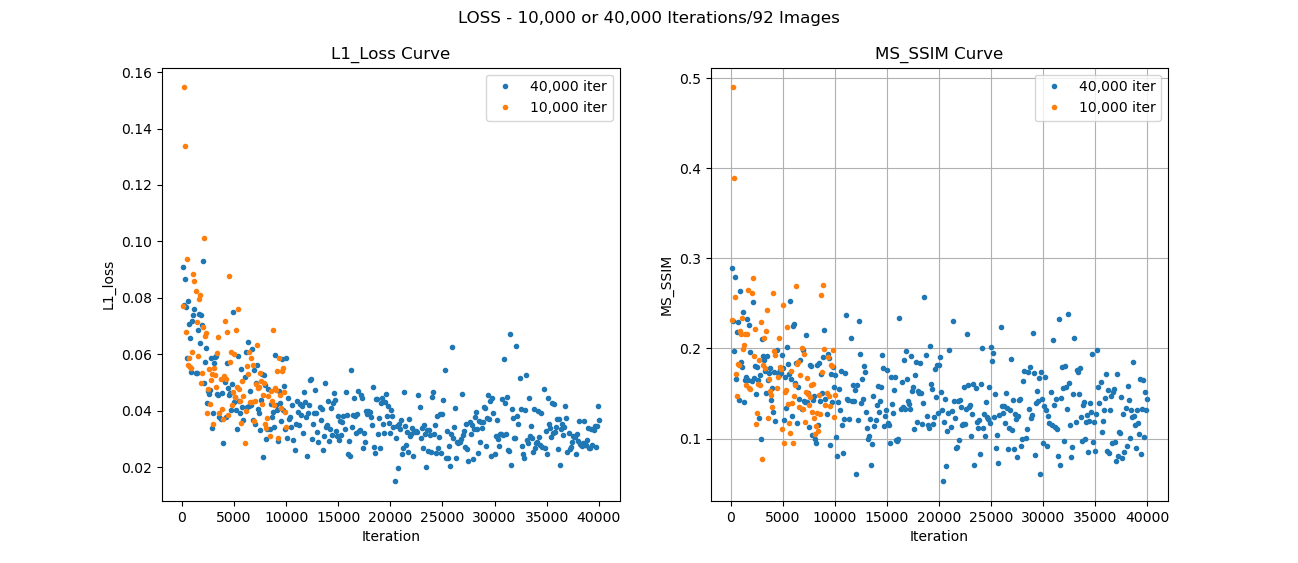

As can be seen the results are probably not representative of the final trained model. The L1 loss starts to converge from an average of 0.11 to an average of 0.04, but there is no indication that this is close to the final converged value.

The PSNR and SSIM metrics computed, by testing the model on 16 different test images, are the following:

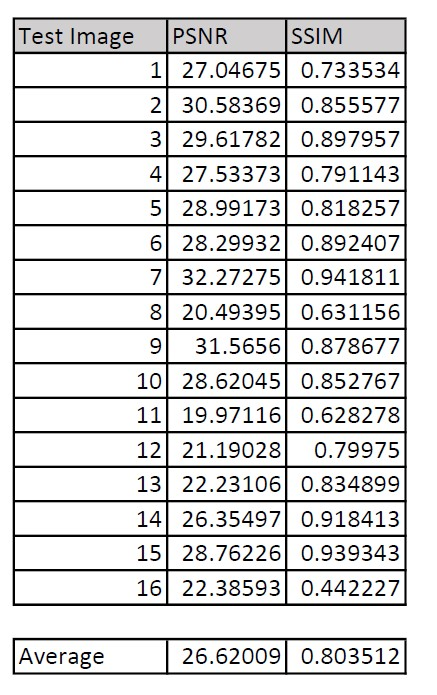

The results of PSNR = 26.62 and SSIM of 0.8035 are far from the original results of 23.85 and 0.75. But this is expected due to the short training performed.

Because of the hardware constraints, we decided to focus our project a bit more on comparative analysis and on testing the final model rather than on large trainings that would require large computational power. Therefore Section 2 presents an analysis on the generalizability of the code and Section 3 a study on the influence of the weight initiallization method on the training.

# 2 -  Testing Generalizability

The table below compares the results obtained from the demo code for demo images (given by the authors) and custom images taken with a Google Pixel 6 phone. The NIQE and Brisque scores of the restored images were determined via a MATLAB script and are provided as well. Only a sub-sample of all the tested images are provided, and even so for each given input image not all amplification versions are provided. We feel that the sample below is sufficient to make some statements about the generalizability of the author's neural network.

The Brisque (Blind/Referenceless Image Spatial Quality Evaluator) score is a number between 1 and 100 assigned to an image by an AI-powered algortihm. The algorithm is designed to be close to human perception, and a lower score indicates a better perceptual image.

We chose to use the Brisque and NIQE scores to rate the images. The NIQE is part of the reproducibility study, to see if the scores obtained using the authors' demo would produce similar NIQE scores to the ones reported in their article.<br>
We chose to evaluate the images for their Brisque scores as well because we felt it would provide a new evaluation of the performance of this neural network.

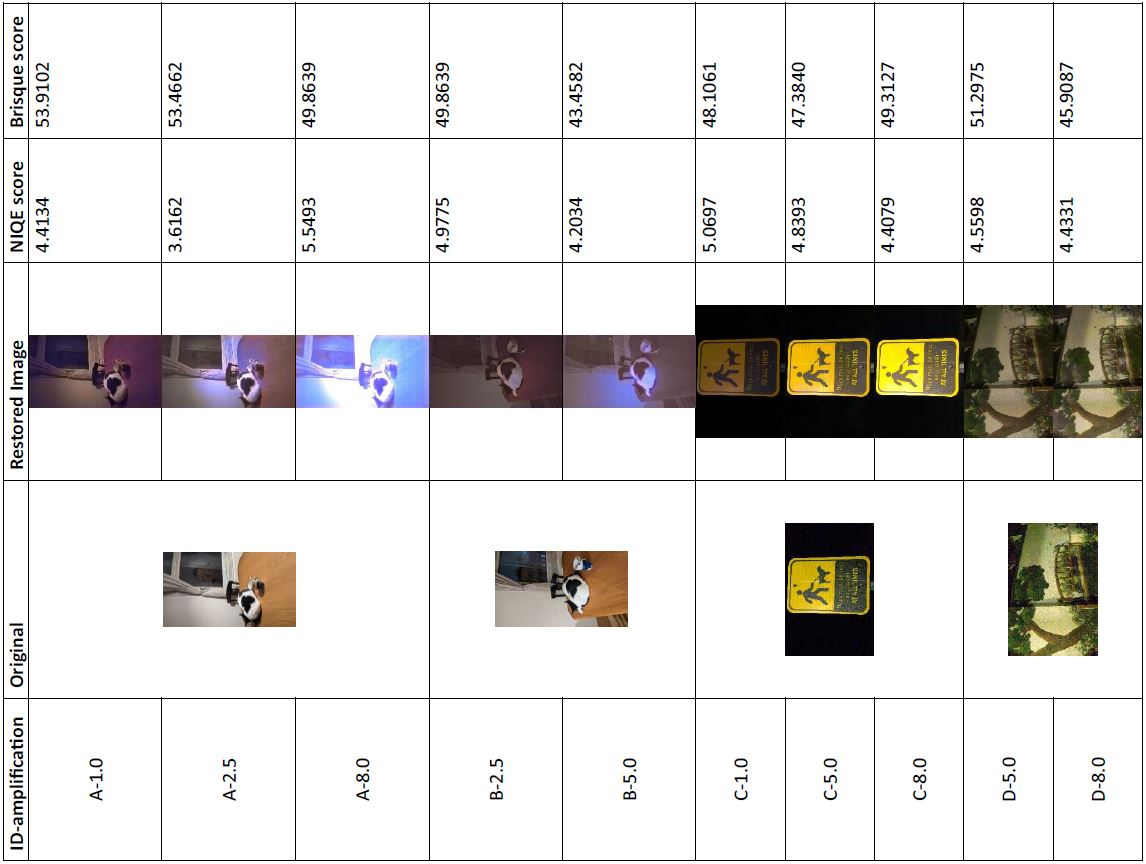

There are several noteworthy aspects of the table above.
Firstly, when comapring the best restoration achieved by the neural network with the original image (not the ground truth, but really the input image!), a qualitative impression is that the restored image is not of better visibility than the original.<br>
Indeed, when the NIQE and brisque scores of the original images are the following: <br>
- Image A: NIQE = 2.053; Brisque = 26.11<br>
- Image B: NIQE = 1.957; Brisque = 11.76<br>
- Image C: NIQE = 4.819; Brisque = 31.11<br>
- Image D: NIQE = 6.460; Brisque = 38.08<br>

In all cases, the brisque score of the orginal image is better than any of the restorations. Further, the NIQE score for the images we took ourselves were significantly better than the restored images.
Suspiciously, the demo images provided scored quite poorly on the NIQE score, and this metric improved with restoration.

# 3 - Testing Weight Initialization


Section 1 presented the (failed) attempted at reproducing th eoriginal results through a full-retraining. This highlighted the limitations imposed by the hardware and time-constraints. This section will focus on an analysis performed despite the computer power limitations. We decided to compare the training performance of the model for different weight initialization methods, since the decision to use Kaiming initialization was not explained in depth in the paper. This was done with the limited training time of 10,000 iterations where the main conclusions can be drown on the initial convergence of the loss function. The four methods compared are the following:

1. Kaiming Initialization (Original Model):
2. Xavier Initialization:
3. Orthogonal Initialization:
4. Normal Initialization:


The results for Kaiming were presented in Section 1. The following figures present the individual results for the xavier,orthogonal and normal inizialization respectively:

The following can be observed:
- Initial L1 loss value for Xavier initialization is more than double the orthogonal/normal one. This is because...
- in MS-SSIM curve the convergence is harder to see in orthogonal and normal than in Xavier. This is because...
- ....

To aid with the comparison, the following image presents the 4 methods together. Note that....

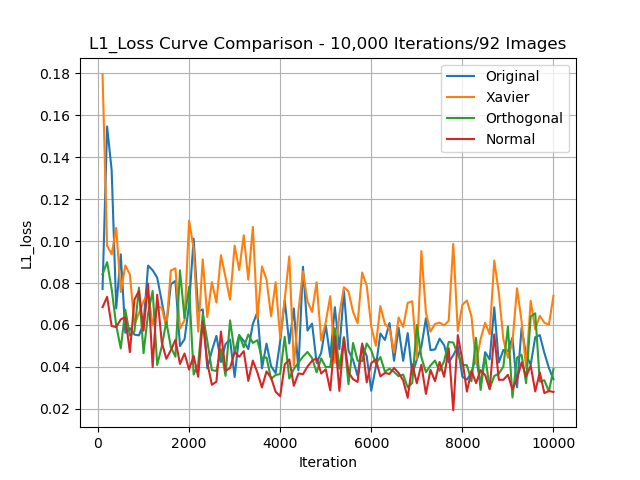

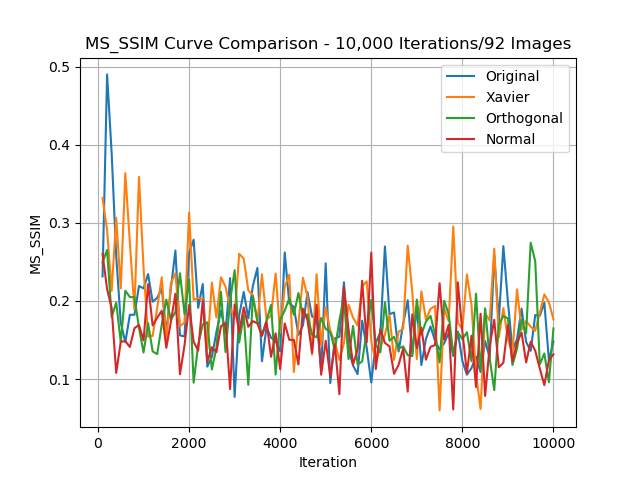

In terms of testing results, the following table summarizes the outcomes of the different methods:


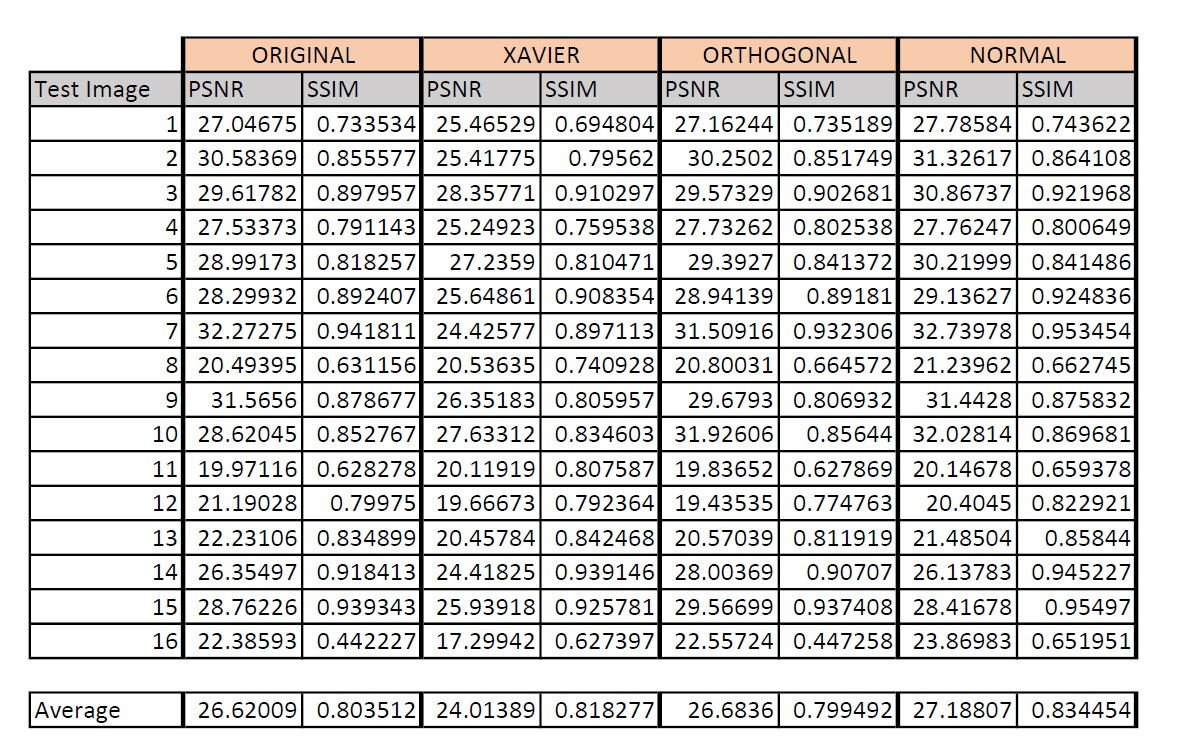

The following can be observed:....
    

# Reproducibility Remarks
xx

# Conclusion

xx